In [1]:
import gzip
import os
import random

import numpy as np
from Bio import SeqIO
from keras.models import model_from_json, Model
from tensorflow import set_random_seed

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list()


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,int(cobinding_data.shape[1]/101)),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,int(cobinding_data.shape[1]/101)),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,int(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,int(region_data.shape[1]/101)),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,int(region_data.shape[1]/101)),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:int(n+101)]
        region[:,:,int(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,int(fold_data.shape[1]/101)), dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1)
        fold = np.zeros((10000,101,int(fold_data.shape[1]/101)), dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,int(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X

Using TensorFlow backend.


In [36]:
training_set_number = 0
protein = "27_ICLIP_TDP43_hg19"
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

def get_positive_samples(protein, t_data, training_set_number, *args ):
    data_sources, X_test = load_data_sources(protein, t_data, training_set_number, *args)
    y_test = get_class(protein, t_data, training_set_number)
    y_test = y_test [:,1]
    positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))
    n = 0

    for i, value in enumerate(y_test):
        if value == 1:
            positive_samples[n] = X_test[i]
            n += 1 
 
    return positive_samples

X_samples = get_positive_samples(protein, 'test', training_set_number, *experiment_set)

with open(f"results/set_{training_set_number}/{protein}/model.json", "r") as json_file:
    json = json_file.read()
    model = model_from_json(json)
    model.load_weights(f"results/set_{training_set_number}/{protein}/weights.h5")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
first_layer_outputs = model.layers[0].output
activation_model = Model(inputs = model.input, outputs = first_layer_outputs)

activations = activation_model.predict(X_samples)
print(activations.shape)     

(2000, 96, 10)


In [31]:
# max_pct = 0.5
# all_activations = np.ravel(activations)
# threshold = maxpct_t * all_activations.max()


# print(threshold)
test_sequences = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
y_test = get_class(protein, "test", training_set_number)
y_test = y_test [:,1]
positive_seq = [seq for seq, label in zip(SeqIO.parse(test_sequences,"fasta"), y_test) if label == 1]

In [39]:
from Bio.Seq import Seq

max_pct=0.5

filters_sequences = {}
for filter_number in range(10):
    filter_activations = activations[:,:,filter_number]

    all_activations = np.ravel(filter_activations)
    activations_mean = all_activations.mean()
    activations_norm = all_activations - activations_mean
    threshold = max_pct * activations_norm.max() + activations_mean

    for case_num, act in enumerate(filter_activations):
        locations = np.argwhere(act > threshold)
        if locations.size != 0:
            for loc in locations.flatten():
                loc = int(loc)
                nucleotides = list(positive_seq[case_num].seq)[loc: loc + 6]
                motif = Seq("".join(nucleotides).replace("T", "U"))

                if filter_number in filters_sequences:
                    filters_sequences[filter_number].append(motif)
                else:
                    filters_sequences[filter_number] = [motif]


                
for filter_number, fil_seq in filters_sequences.items():
    if not os.path.exists('test_motifs/{}'.format(protein)):
        os.mkdir('test_motifs/{}'.format(protein))
    with open(f"test_motifs/{protein}/filter{filter_number}_motif.txt", "w") as motif_file:
        for motif in fil_seq:
            motif_file.write(str(motif) + "\n")



0.6639365255832672
0.9464169144630432
0.781870648264885
0.9657856822013855
0.46774134039878845
0.727801151573658
0.4989057779312134
1.2489061504602432
0.9553701281547546
0.4875513017177582


In [88]:
from Bio.Seq import Seq


filters_sequences = {}
for case_num, case in enumerate(activations):
    #shape is case/binding site, sequence, filter (2000, 96, 10)
    for filter_number, filter_act in enumerate(case.T):
        locations = np.argwhere(filter_act > threshold)
        if locations.size != 0:
            for loc in locations:
                loc = int(loc)

                nucleotides = list(positive_seq[case_num].seq)[loc: loc + 6]
                motif = Seq("".join(nucleotides).replace("T", "U"))

                if filter_number in filters_sequences:
                    filters_sequences[filter_number].append(motif)
                else:
                    filters_sequences[filter_number] = [motif]


                
for filter_number, fil_seq in filters_sequences.items():
    if not os.path.exists('test_motifs/{}'.format(protein)):
        os.mkdir('test_motifs/{}'.format(protein))
    with open(f"test_motifs/{protein}/filter{filter_number}_motif.txt", "w") as motif_file:
        for motif in fil_seq:
            motif_file.write(str(motif) + "\n")
        

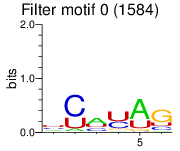

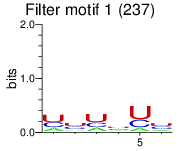

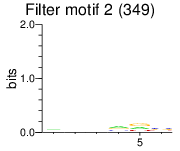

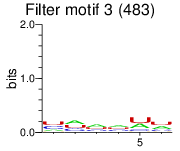

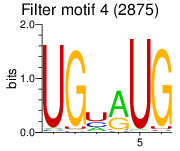

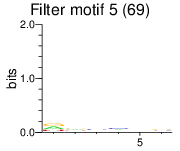

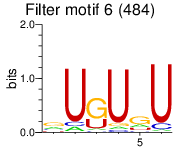

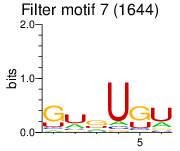

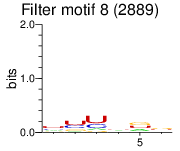

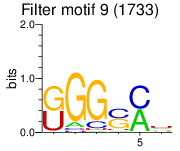

In [40]:
from IPython.display import display, Image 
for filter_number, fil_seq in filters_sequences.items():
    title = (f"'Logo for filter {filter_number} ({len(fil_seq)})'")
    cmd = (f"weblogo -f test_motifs/{protein}/filter{filter_number}_motif.txt -F png -o test_motifs/{protein}/motif{filter_number}.png -P '' --title 'Filter motif {filter_number} ({len(fil_seq)})' --size large --errorbars NO --show-xaxis YES --show-yaxis YES -A rna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U'")
    os.system(cmd)

    
    display(Image('test_motifs/{1}/motif{0}.png'.format(filter_number, protein)))


In [3]:
PROTEINS = ['1 Ago/EIF', '2 Ago2-MNase', '3 Ago2-1', '4 Ago2-2', '5 Ago2', '6 eIF4AIII-1', '7 eIF4AIII-2', '8 ELAVL1-1', '9 ELAVL1-MNase', '10 ELAVL1A', '12 ESWR1', '13 FUS', '14 Mut FUS', '15 IGFBP1-3', '16 hnRNPC-1', '17 hnRNPC-2', '18 hnRNPL-1', '19 hnRNPL-2', '20 hnRNPL-like', '21 MOV10', '22 Nsun2', '23 PUM2', '24 QKI', '25 SRSF1' , '26 TAF15', '27 TDP-43', '28 TIA1', '29 TIAL1', '30 U2AF2', '31 U2AF2(KD)']
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
PROTEIN_NAMES = {protein:name for (protein,name) in zip(protein_list, PROTEINS)}
PROTEIN_NAMES

{'1_PARCLIP_AGO1234_hg19': '1 Ago/EIF',
 '2_PARCLIP_AGO2MNASE_hg19': '2 Ago2-MNase',
 '3_HITSCLIP_Ago2_binding_clusters': '3 Ago2-1',
 '4_HITSCLIP_Ago2_binding_clusters_2': '4 Ago2-2',
 '5_CLIPSEQ_AGO2_hg19': '5 Ago2',
 '6_CLIP-seq-eIF4AIII_1': '6 eIF4AIII-1',
 '7_CLIP-seq-eIF4AIII_2': '7 eIF4AIII-2',
 '8_PARCLIP_ELAVL1_hg19': '8 ELAVL1-1',
 '9_PARCLIP_ELAVL1MNASE_hg19': '9 ELAVL1-MNase',
 '10_PARCLIP_ELAVL1A_hg19': '10 ELAVL1A',
 '12_PARCLIP_EWSR1_hg19': '12 ESWR1',
 '13_PARCLIP_FUS_hg19': '13 FUS',
 '14_PARCLIP_FUS_mut_hg19': '14 Mut FUS',
 '15_PARCLIP_IGF2BP123_hg19': '15 IGFBP1-3',
 '16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters': '16 hnRNPC-1',
 '17_ICLIP_HNRNPC_hg19': '17 hnRNPC-2',
 '18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome': '18 hnRNPL-1',
 '19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome': '19 hnRNPL-2',
 '20_ICLIP_hnRNPlike_U266_group_4